In [1]:
# import some keras and basic module 

from __future__ import print_function 
import tensorflow.keras as keras

# data set cifar 10 
from tensorflow.keras.datasets import cifar10 

# basic preprocesssing for image data 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# construct neural network 
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten 
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import os 

import numpy as np 

import matplotlib.pyplot as plt

from tensorflow.keras.utils import plot_model
import tensorflow as tf 

config = tf.ConfigProto()
tf.enable_eager_execution(config=config)
import time
from fmp import *

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:

## basic parameters 
batch_size = 40 
num_classes = 10 
num_epochs = 300 
is_data_augmentation = True 
model_dir = 'models'
model_filename = 'model_BeatLeNet5_5_fmp.h'


In [3]:
#read data and split data into train and test set

(train_set,train_label),(test_set,test_label) = cifar10.load_data() 

print('the shape of training data set is: ',train_set.shape) 


the shape of training data set is:  (50000, 32, 32, 3)


In [4]:
# Convert class label to binary vector 
train_label = keras.utils.to_categorical(train_label,num_classes)
test_label  = keras.utils.to_categorical(test_label,num_classes) 
print(train_label.shape)
print(test_label.shape)

(50000, 10)
(10000, 10)


Instructions for updating:
`seed2` and `deterministic` args are deprecated.  Use fractional_max_pool_v2.


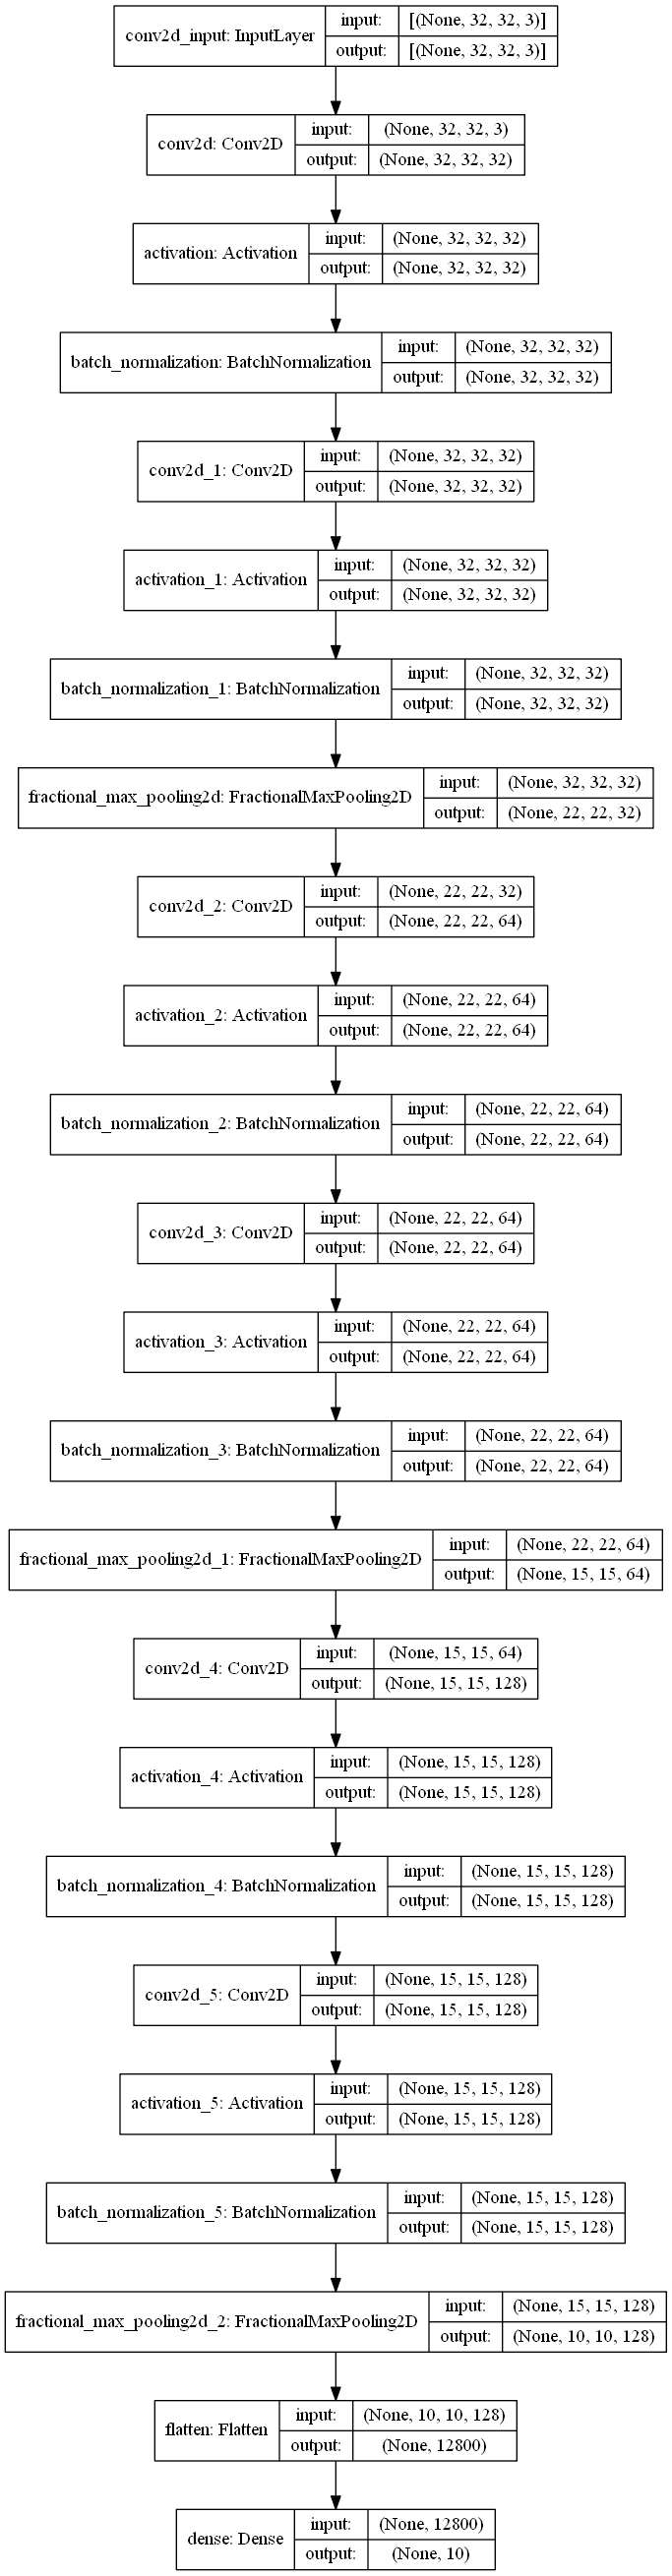

In [5]:
# construct the model 


cnn_model = Sequential()
# Block 1
cnn_model.add(Conv2D(64, (3, 3),input_shape=X_train.shape[1:], padding='same'))
cnn_model.add(LeakyReLU(alpha = 0.3))
cnn_model.add(Conv2D(64, (3, 3), padding='same'))
cnn_model.add(LeakyReLU(alpha = 0.3))
cnn_model.add(FractionalPooling2D(pool_ratio=(1, 1.6, 1.6, 1),pseudo_random = True,overlap=True))
# Block 2
cnn_model.add(Conv2D(128, (3, 3), padding='same'))
cnn_model.add(LeakyReLU(alpha = 0.3))
cnn_model.add(Conv2D(128, (3, 3), padding='same'))
cnn_model.add(LeakyReLU(alpha = 0.3))
cnn_model.add(FractionalPooling2D(pool_ratio=(1, 1.25, 1.25, 1),pseudo_random = True,overlap=True))


# Block 3
cnn_model.add(Conv2D(256, (3, 3), padding='same'))
cnn_model.add(LeakyReLU(alpha = 0.3))
cnn_model.add(Conv2D(256, (3, 3), padding='same'))
cnn_model.add(LeakyReLU(alpha = 0.3))
cnn_model.add(Conv2D(256, (3, 3), padding='same'))
cnn_model.add(LeakyReLU(alpha = 0.3))
cnn_model.add(FractionalPooling2D(pool_ratio=(1, 1.6, 1.6, 1),pseudo_random = True,overlap=True))


# Block 4
cnn_model.add(Conv2D(256, (3, 3), padding='same'))
cnn_model.add(LeakyReLU(alpha = 0.3))
cnn_model.add(Conv2D(256, (3, 3), padding='same'))
cnn_model.add(LeakyReLU(alpha = 0.3))
cnn_model.add(Conv2D(256, (3, 3), padding='same'))
cnn_model.add(LeakyReLU(alpha = 0.3))
cnn_model.add(FractionalPooling2D(pool_ratio=(1, 1.25, 1.25, 1),pseudo_random = True,overlap=True))


# Block 5
cnn_model.add(Conv2D(512, (3, 3), padding='same'))
cnn_model.add(LeakyReLU(alpha = 0.3))
cnn_model.add(Conv2D(512, (3, 3), padding='same'))
cnn_model.add(LeakyReLU(alpha = 0.3))
cnn_model.add(Conv2D(512, (3, 3), padding='same'))
cnn_model.add(LeakyReLU(alpha = 0.3))
cnn_model.add(FractionalPooling2D(pool_ratio=(1, 1.6, 1.6, 1),pseudo_random = True,overlap=True))
# Block 6
cnn_model.add(Conv2D(512, (3, 3), padding='same'))
cnn_model.add(LeakyReLU(alpha = 0.3))
cnn_model.add(Conv2D(512, (3, 3), padding='same'))
cnn_model.add(LeakyReLU(alpha = 0.3))
cnn_model.add(Conv2D(512, (3, 3), padding='same'))
cnn_model.add(LeakyReLU(alpha = 0.3))
cnn_model.add(FractionalPooling2D(pool_ratio=(1, 1.25, 1.25, 1),pseudo_random = True,overlap=True))
cnn_model.add(Reshape((16,512)))

# fc layer_1
cnn_model.add(Dense(1024, kernel_constraint=maxnorm(3)))
cnn_model.add(LeakyReLU(alpha = 0.3))
# fc_layer_2
cnn_model.add(Dense(512, kernel_constraint=maxnorm(3)))
cnn_model.add(LeakyReLU(alpha = 0.3))


cnn_model.add(Flatten())

cnn_model.add(Dense(num_classes, activation='softmax'))
plot_model(cnn_model, show_shapes=True,to_file='fmp_model_1.png')


In [6]:


# initialization of optimizer 
opt = keras.optimizers.Adadelta(1,decay=1e-4) 

# train the model by optimizer
cnn_model.compile(loss = 'categorical_crossentropy',
              optimizer = opt,
              metrics = ['accuracy'])

train_set = train_set.astype('float32')
test_set = test_set.astype('float32') 

train_set /= 255 
test_set /= 255 



# set parameter for data augmentation 
data_transform_parameters = {
                            "rotation_range": 15,
                            "width_shift_range":0.1,
                            "height_shift_range":0.1,
                            "horizontal_flip":True
                            }

# get object of augmentation data generator 
augment_data_set_generator = ImageDataGenerator(data_transform_parameters)    


# get augmented data set 

augment_train_set = augment_data_set_generator.apply_transform(train_set,data_transform_parameters)
print(augment_train_set.shape)


# Limit GPU device to the first GPU 
#gpus = tf.config.experimental.list_physical_devices('GPU')
#if gpus:
  # Restrict TensorFlow to only use the first GPU
#  try:
#    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
#    print(e)


# train model by GPU 
with tf.device('/device:GPU:0'):
    cnn_history = cnn_model.fit(augment_train_set, train_label,
              batch_size=batch_size,
              epochs=num_epochs,
              validation_data=(test_set, test_label),
              shuffle=True)

# save model and weights 
if not os.path.isdir(model_dir): 
    os.makedirs(model_dir) 
model_path = os.path.join(model_dir,model_filename)
cnn_model.save(model_path)
print("CNN Model saved at %s " % model_path)

# Score trained model 
infer_time = 0 
infer_time_st = time.time()
test_loss_value, test_metric_value = cnn_model.evaluate(test_set,test_label,verbose =1 )
infer_time_ed = time.time()
train_loss_value, train_metric_value = cnn_model.evaluate(train_set,train_label,verbose =1)
infer_time = infer_time_ed - infer_time_st

print("Train loss: ", train_loss_value) 
print("Trian metric: ", train_metric_value)

print("Test loss: ", test_loss_value)
print("Test accuracy:", test_metric_value)
# print(cnn_history.history)


Using real-time data augmentation.
(50000, 32, 32, 3)
Train on 50000 samples, validate on 10000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/300
50000/50000 [==============================] - 99s 2ms/sample - loss: 2.0091 - acc: 0.5097 - val_loss: 1.5614 - val_acc: 0.5271
Epoch 2/300
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.4591 - acc: 0.6448 - val_loss: 1.3895 - val_acc: 0.5880
Epoch 3/300
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.2192 - acc: 0.7057 - val_loss: 1.1233 - val_acc: 0.6446
Epoch 4/300
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.1297 - acc: 0.7352 - val_loss: 0.9481 - val_acc: 0.7046
Epoch 5/300
50000/50000 [==============================] - 96s 2ms/sample - loss: 1.0434 - acc: 0.7555 - val_loss: 1.0474 - val_acc: 0.6997
Epoch 6/300
50000/50000 [==============================] - 95s 2ms/sample - loss: 1.0162 - acc: 0.7729

50000/50000 [==============================] - 94s 2ms/sample - loss: 0.4157 - acc: 0.9122 - val_loss: 0.9015 - val_acc: 0.8005
Epoch 57/300
50000/50000 [==============================] - 94s 2ms/sample - loss: 0.4142 - acc: 0.9105 - val_loss: 0.7853 - val_acc: 0.8184
Epoch 58/300
50000/50000 [==============================] - 94s 2ms/sample - loss: 0.4123 - acc: 0.9129 - val_loss: 0.8294 - val_acc: 0.8170
Epoch 59/300
50000/50000 [==============================] - 94s 2ms/sample - loss: 0.4080 - acc: 0.9136 - val_loss: 0.8372 - val_acc: 0.8144
Epoch 60/300
50000/50000 [==============================] - 94s 2ms/sample - loss: 0.4079 - acc: 0.9150 - val_loss: 0.8246 - val_acc: 0.8147
Epoch 61/300
50000/50000 [==============================] - 94s 2ms/sample - loss: 0.4014 - acc: 0.9165 - val_loss: 0.8301 - val_acc: 0.8083
Epoch 62/300
50000/50000 [==============================] - 94s 2ms/sample - loss: 0.3989 - acc: 0.9175 - val_loss: 0.8810 - val_acc: 0.8183
Epoch 63/300
50000/50000 [

50000/50000 [==============================] - 93s 2ms/sample - loss: 0.3612 - acc: 0.9328 - val_loss: 0.8903 - val_acc: 0.8235
Epoch 115/300
50000/50000 [==============================] - 93s 2ms/sample - loss: 0.3566 - acc: 0.9335 - val_loss: 0.8360 - val_acc: 0.8342
Epoch 116/300
50000/50000 [==============================] - 93s 2ms/sample - loss: 0.3593 - acc: 0.9332 - val_loss: 0.8646 - val_acc: 0.8210
Epoch 117/300
50000/50000 [==============================] - 94s 2ms/sample - loss: 0.3569 - acc: 0.9348 - val_loss: 0.8422 - val_acc: 0.8214
Epoch 118/300
50000/50000 [==============================] - 93s 2ms/sample - loss: 0.3536 - acc: 0.9341 - val_loss: 0.7947 - val_acc: 0.8307
Epoch 119/300
50000/50000 [==============================] - 93s 2ms/sample - loss: 0.3559 - acc: 0.9347 - val_loss: 0.8630 - val_acc: 0.8265
Epoch 120/300
50000/50000 [==============================] - 93s 2ms/sample - loss: 0.3560 - acc: 0.9351 - val_loss: 0.8524 - val_acc: 0.8245
Epoch 121/300
50000/

Epoch 172/300
50000/50000 [==============================] - 93s 2ms/sample - loss: 0.3448 - acc: 0.9396 - val_loss: 0.8305 - val_acc: 0.8350
Epoch 173/300
50000/50000 [==============================] - 93s 2ms/sample - loss: 0.3488 - acc: 0.9381 - val_loss: 0.8775 - val_acc: 0.8237
Epoch 174/300
50000/50000 [==============================] - 93s 2ms/sample - loss: 0.3446 - acc: 0.9397 - val_loss: 0.8766 - val_acc: 0.8324
Epoch 175/300
50000/50000 [==============================] - 93s 2ms/sample - loss: 0.3476 - acc: 0.9382 - val_loss: 0.8438 - val_acc: 0.8360
Epoch 176/300
50000/50000 [==============================] - 93s 2ms/sample - loss: 0.3462 - acc: 0.9392 - val_loss: 0.8412 - val_acc: 0.8299
Epoch 177/300
50000/50000 [==============================] - 93s 2ms/sample - loss: 0.3436 - acc: 0.9403 - val_loss: 0.8502 - val_acc: 0.8303
Epoch 178/300
50000/50000 [==============================] - 93s 2ms/sample - loss: 0.3431 - acc: 0.9399 - val_loss: 0.9039 - val_acc: 0.8248
Epoch 

Epoch 287/300
50000/50000 [==============================] - 94s 2ms/sample - loss: 0.3397 - acc: 0.9418 - val_loss: 0.8452 - val_acc: 0.8367
Epoch 288/300
50000/50000 [==============================] - 94s 2ms/sample - loss: 0.3379 - acc: 0.9430 - val_loss: 0.8948 - val_acc: 0.8254
Epoch 289/300
50000/50000 [==============================] - 93s 2ms/sample - loss: 0.3343 - acc: 0.9434 - val_loss: 0.8997 - val_acc: 0.8309
Epoch 290/300
50000/50000 [==============================] - 93s 2ms/sample - loss: 0.3381 - acc: 0.9438 - val_loss: 0.8107 - val_acc: 0.8394
Epoch 291/300
50000/50000 [==============================] - 94s 2ms/sample - loss: 0.3323 - acc: 0.9455 - val_loss: 0.8554 - val_acc: 0.8328
Epoch 292/300
50000/50000 [==============================] - 93s 2ms/sample - loss: 0.3350 - acc: 0.9427 - val_loss: 0.8271 - val_acc: 0.8382
Epoch 293/300
50000/50000 [==============================] - 93s 2ms/sample - loss: 0.3368 - acc: 0.9429 - val_loss: 0.8849 - val_acc: 0.8305
Epoch 

Text(0.5, 1.0, 'test loss and test accuracy')

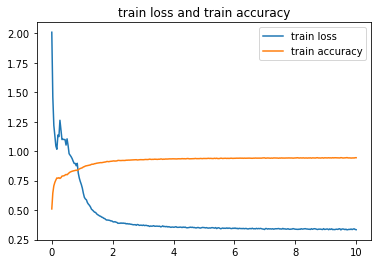

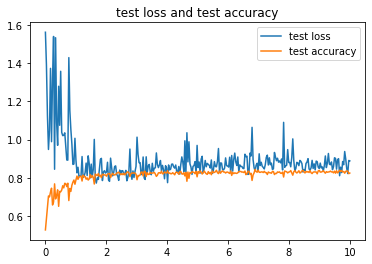

In [7]:

# get history data
epoth_x = np.linspace(0, 10, num_epochs, endpoint=True)
train_loss = cnn_history.history['loss']
train_accuracy = cnn_history.history['acc']
test_loss = cnn_history.history['val_loss']
test_accuracy = cnn_history.history['val_acc']

# plot train loss and accuracy
plt.figure() 
plt.plot(epoth_x, train_loss,label = 'train loss')
plt.plot(epoth_x,train_accuracy,label = 'train accuracy')
plt.title("train loss and train accuracy")
plt.legend()


# plot test loss and accuracy
plt.figure() 
plt.plot(epoth_x, test_loss, label = 'test loss')
plt.plot(epoth_x,test_accuracy, label = 'test accuracy')
plt.legend()
plt.title("test loss and test accuracy")